In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

In [2]:
df_account_raw = pd.read_csv('data/raw_account_70_new.csv', index_col=False, header=0)
df_data_raw = pd.read_csv('data/raw_data_70_new.csv', index_col=False, header=0)
df_enquiry_raw = pd.read_csv('data/raw_enquiry_70_new.csv', index_col=False, header=0)

/Users/CrazyGear/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/CrazyGear/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (12,20,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [94]:
df_account_test_raw = pd.read_csv('data/raw_account_30_new.csv', index_col=False, header=0)
df_data_test_raw = pd.read_csv('data/raw_data_30_new.csv', index_col=False, header=0)
df_enquiry_test_raw = pd.read_csv('data/raw_enquiry_30_new.csv', index_col=False, header=0)

/Users/CrazyGear/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/CrazyGear/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (12,20,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Clearning

#### Missing values - equiry table

In [3]:
df_enquiry = df_enquiry_raw.drop(df_enquiry_raw.index[df_enquiry_raw['enq_amt'].isna()])

In [95]:
df_enquiry_test = df_enquiry_test_raw.drop(df_enquiry_test_raw.index[df_enquiry_test_raw['enq_amt'].isna()])

In [4]:
df_account = df_account_raw
df_data = df_data_raw

In [96]:
df_account_test = df_account_test_raw
df_data_test = df_data_test_raw

## Feature Engineering

In [5]:
# engineered dataframe
df_engineered = df_data[['customer_no','Bad_label']]

In [97]:
# engineered dataframe
df_engineered_test = df_data_test[['customer_no','Bad_label']]

In [6]:
from datetime import datetime

def col_to_datetime(df, col_name, format="%d-%b-%y"):
    # %d-%b-%y, e.g. 19-Dec-13
    if not isinstance(col_name,list):
        col_name = [col_name]
    for name in col_name:
        df[name] = pd.to_datetime(df[name], format=format)

#### 1. `payment_history_avg_dpd_0_29_bucket`
mean count of accounts that is in 0-29 dpd bucket throughout the payment history

In [7]:
def dpd_history(row):
    history=[]
    # history 1, make use of syntax sugar, same effect as how h2 is calculated
    history1 = row['paymenthistory1']
    h1 = history1 and not pd.isna(history1) and history1[3:-3] or ''

    # history 2
    history2 = row['paymenthistory2']
    if history2 and not pd.isna(history2):
        h2=history2[3:-3]
    else:
        h2=''

    # concat h1 and h2
    h = h1+h2

    if len(h)%3!=0:
        print('length of payment history should be multiples of 3')

    for i in range(int(len(h)/3)):
        try:
            dpd = int(h[3*i:3*i+3])
            history.append(dpd)
        except:
            history.append(h[3*i:3*i+3])
    return history

In [8]:
df_account['dpd_history'] = df_account.apply(dpd_history, axis=1)

In [98]:
df_account_test['dpd_history'] = df_account_test.apply(dpd_history, axis=1)

In [9]:
def avg_dpd_0_29(df):
    dpd_account_list=[]
    for index, row in df.iterrows():
        dpd_list = row['dpd_history']
        flag_above_30_dpd = False
        for dpd in dpd_list:
            if isinstance(dpd, int) and dpd>29: # found dpd>30, not in 0_29 bucket
                flag_above_30_dpd = True
                break
        dpd_account_list.append(0 if flag_above_30_dpd else 1)
    return sum(dpd_account_list)/len(dpd_account_list)

df_temp = df_account.groupby(['customer_no']).apply(avg_dpd_0_29).reset_index(name='payment_history_avg_dpd_0_29_bucket')
df_engineered = pd.merge(df_engineered, df_temp, on=['customer_no'], how='left')

In [148]:
df_temp = df_account_test.groupby(['customer_no']).apply(avg_dpd_0_29).reset_index(name='payment_history_avg_dpd_0_29_bucket')
df_engineered_test = pd.merge(df_engineered_test, df_temp, on=['customer_no'], how='left')

#### 2 `total_diff_lastpaymt_opened_dt`
The total duration between last payment date and account opened date of all accounts

In [10]:
col_to_datetime(df_account, ['last_paymt_dt','opened_dt'])
df_temp = df_account.groupby(['customer_no']) \
    .apply(lambda group: (group['last_paymt_dt']-group['opened_dt']).dt.days.sum()) \
    .reset_index(name='total_diff_lastpaymt_opened_dt')
df_engineered = pd.merge(df_engineered, df_temp, on=['customer_no'], how='inner')

In [100]:
col_to_datetime(df_account_test, ['last_paymt_dt','opened_dt'])
df_temp = df_account_test.groupby(['customer_no']) \
    .apply(lambda group: (group['last_paymt_dt']-group['opened_dt']).dt.days.sum()) \
    .reset_index(name='total_diff_lastpaymt_opened_dt')
df_engineered_test = pd.merge(df_engineered_test, df_temp, on=['customer_no'], how='inner')

#### 3. `min_months_last_30_plus`
The smallest number of months passed before first 30+ dpd appeared for each account.

In [11]:
def min_months_lt_30(df):
    dpd_list=[]
    for index, row in df.iterrows():
        count=0
        for dpd in row['dpd_history']:
            if isinstance(dpd, int) and dpd>29: # found dpd>30, not in 0_29 bucket
                break
            else:
                count+=1
        dpd_list.append(count)
    return min(dpd_list)

# df_temp = 
df_temp = df_account.groupby(['customer_no']).apply(min_months_lt_30).reset_index(name='min_months_last_30_plus')
df_engineered = pd.merge(df_engineered, df_temp, on=['customer_no'], how='left')

In [101]:
df_temp = df_account_test.groupby(['customer_no']).apply(min_months_lt_30).reset_index(name='min_months_last_30_plus')
df_engineered_test = pd.merge(df_engineered_test, df_temp, on=['customer_no'], how='left')

#### 4. `utilisation_trend`
[total cur_bal_amt / total credit
limit]/
[mean cur_bal_amt / (mean
credit limit+ mean_cashlimit)]

In [12]:
def utilisation_trend(group):
    # extra code to handle nan cases
    cur_balance_amt = group[~group['cur_balance_amt'].isna()]['cur_balance_amt'].as_matrix()
    creditlimit = group[~group['creditlimit'].isna()]['creditlimit'].as_matrix()
    cashlimit = group[~group['cashlimit'].isna()]['cashlimit'].as_matrix()
    credit_mean = 0 if len(creditlimit)==0 else creditlimit.mean()
    cash_mean = 0 if len(cashlimit)==0 else cashlimit.mean()
    return len(cur_balance_amt)/(creditlimit.sum()+1e-5)*(credit_mean+cash_mean)

df_temp = df_account.groupby(['customer_no']) \
    .apply(utilisation_trend).reset_index(name='utilisation_trend')
df_engineered = pd.merge(df_engineered, df_temp, on=['customer_no'], how='left')

In [102]:
df_temp = df_account_test.groupby(['customer_no']) \
    .apply(utilisation_trend).reset_index(name='utilisation_trend')
df_engineered_test = pd.merge(df_engineered_test, df_temp, on=['customer_no'], how='left')

#### 5. `count_enquiry_recency_365` 
number of enquiry made in past 365 days

In [13]:
# convert datetime column to the right dtype
col_to_datetime(df_enquiry, ['dt_opened','upload_dt','enquiry_dt'])

In [103]:
# convert datetime column to the right dtype
col_to_datetime(df_enquiry_test, ['dt_opened','upload_dt','enquiry_dt'])

In [14]:
df_temp = df_enquiry.groupby(['customer_no']).apply(lambda group: (group['enquiry_dt']>datetime(2014,12,31)).sum()).reset_index(name='count_enquiry_recency_365')
df_engineered = pd.merge(df_engineered, df_temp, on=['customer_no'], how='inner')

In [104]:
df_temp = df_enquiry_test.groupby(['customer_no']).apply(lambda group: (group['enquiry_dt']>datetime(2014,12,31)).sum()).reset_index(name='count_enquiry_recency_365')
df_engineered_test = pd.merge(df_engineered_test, df_temp, on=['customer_no'], how='inner')

#### 6. `ratio_currbalance_creditlimit`  
$$\frac{total\ cur\_bal\_amt}{total\ credit\ limit}$$

In [15]:
df_temp = df_account.groupby(['customer_no']).apply(lambda group: (group['cur_balance_amt']).sum()/((group['creditlimit']).sum()+0.01)).reset_index(name='ratio_currbalance_creditlimit')
df_engineered = pd.merge(df_engineered, df_temp, on=['customer_no'], how='inner')

In [105]:
df_temp = df_account_test.groupby(['customer_no']).apply(lambda group: (group['cur_balance_amt']).sum()/((group['creditlimit']).sum()+0.01)).reset_index(name='ratio_currbalance_creditlimit')
df_engineered_test = pd.merge(df_engineered_test, df_temp, on=['customer_no'], how='inner')

#### 7. `mean_diff_lastpaymt_opened_dt`
The average duration between last payment date and account opened date of all accounts

In [16]:
col_to_datetime(df_account, ['last_paymt_dt','opened_dt'])
def mean_diff_lastpay_open(group):
    group = group[~group['last_paymt_dt'].isna()]
    group = group[~group['opened_dt'].isna()]
    days = (group['last_paymt_dt']-group['opened_dt']).dt.days.as_matrix()
    return 0 if len(days)==0 else days.sum()/len(days)

df_temp = df_account.groupby(['customer_no']).apply(mean_diff_lastpay_open)\
    .reset_index(name='mean_diff_lastpaymt_opened_dt')
df_engineered = pd.merge(df_engineered, df_temp, on=['customer_no'], how='inner')

In [106]:
col_to_datetime(df_account_test, ['last_paymt_dt','opened_dt'])

df_temp = df_account_test.groupby(['customer_no']).apply(mean_diff_lastpay_open)\
    .reset_index(name='mean_diff_lastpaymt_opened_dt')
df_engineered_test = pd.merge(df_engineered_test, df_temp, on=['customer_no'], how='inner')

#### 8.`mean_diff_open_enquiry_dt`
average difference between enquiry dt_opened date and enquiry date

In [17]:
col_to_datetime(df_enquiry, ['dt_opened','enquiry_dt'])
df_temp = df_enquiry.groupby(['customer_no']).apply(lambda group: (group['enquiry_dt']-group['dt_opened']).dt.days.mean()).reset_index(name='mean_diff_open_enquiry_dt')
df_engineered = pd.merge(df_engineered, df_temp, on=['customer_no'], how='inner')

In [107]:
col_to_datetime(df_enquiry_test, ['dt_opened','enquiry_dt'])
df_temp = df_enquiry_test.groupby(['customer_no']).apply(lambda group: (group['enquiry_dt']-group['dt_opened']).dt.days.mean()).reset_index(name='mean_diff_open_enquiry_dt')
df_engineered_test = pd.merge(df_engineered_test, df_temp, on=['customer_no'], how='inner')

#### 9. `payment_history_mean_length`
average length of payment_history variable

In [18]:
def avg_payment_length(df):
    payment_length = []
    for index, row in df.iterrows():
        payment_length.append(len(row['dpd_history']))
    return sum(payment_length)/len(payment_length)

# df_temp = 
df_temp = df_account.groupby(['customer_no']) \
    .apply(avg_payment_length).reset_index(name='payment_history_mean_length')
df_engineered = pd.merge(df_engineered, df_temp, on=['customer_no'], how='left')

In [108]:
df_temp = df_account_test.groupby(['customer_no']) \
    .apply(avg_payment_length).reset_index(name='payment_history_mean_length')
df_engineered_test = pd.merge(df_engineered_test, df_temp, on=['customer_no'], how='left')

#### 10. `max_freq_enquiry` 
most frequent enquiry purpose

In [19]:
from collections import Counter

df_temp = df_enquiry.groupby(['customer_no']) \
    .apply(lambda group: Counter(list(group['enq_purpose'])).most_common(1)[0][0]) \
    .reset_index(name='max_freq_enquiry')
df_engineered = pd.merge(df_engineered, df_temp, on=['customer_no'], how='inner')

In [109]:
df_temp = df_enquiry_test.groupby(['customer_no']) \
    .apply(lambda group: Counter(list(group['enq_purpose'])).most_common(1)[0][0]) \
    .reset_index(name='max_freq_enquiry')
df_engineered_test = pd.merge(df_engineered_test, df_temp, on=['customer_no'], how='inner')

#### 11. `count_enquiry_recency_90` 
number of enquiry made in past 90 days  
TODO: when is considered as past 90?

In [20]:
df_temp = df_enquiry.groupby(['customer_no']).apply(lambda group: (group['enquiry_dt']>datetime(2015,9,30)).sum()).reset_index(name='count_enquiry_recency_90')
df_engineered = pd.merge(df_engineered, df_temp, on=['customer_no'], how='inner')

In [110]:
df_temp = df_enquiry_test.groupby(['customer_no']).apply(lambda group: (group['enquiry_dt']>datetime(2015,9,30)).sum()).reset_index(name='count_enquiry_recency_90')
df_engineered_test = pd.merge(df_engineered_test, df_temp, on=['customer_no'], how='inner')

#### 12. `perc_unsecured_others`
ratio of secured loan type enquiry purpose to total enquiry purpose made

In [21]:
secure_loan_type_list = [1,2,3,4,7,11,13,15,17,31,32,33,34,42,51,52,53,54,55,56,57,58,59,60]

df_temp = df_enquiry.groupby(['customer_no']) \
    .apply(lambda group: group['enq_purpose'].isin(secure_loan_type_list).astype(int).sum()/group['enq_purpose'].count()) \
    .reset_index(name='perc_unsecured_others')
df_engineered = pd.merge(df_engineered, df_temp, on=['customer_no'], how='left')

In [134]:
df_temp = df_enquiry_test.groupby(['customer_no']) \
    .apply(lambda group: group['enq_purpose'].isin(secure_loan_type_list).astype(int).sum()/group['enq_purpose'].count()) \
    .reset_index(name='perc_unsecured_others')
df_engineered_test = pd.merge(df_engineered_test, df_temp, on=['customer_no'], how='left')

In [150]:
del(df_engineered_test['perc_unsecured_others_y'])

In [130]:
# get information about data, make sure they are in good data type(numeric) and shape(no missing values)
df_engineered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23787 entries, 0 to 23786
Data columns (total 14 columns):
customer_no                            23787 non-null int64
Bad_label                              23787 non-null int64
payment_history_avg_dpd_0_29_bucket    23787 non-null float64
total_diff_lastpaymt_opened_dt         23787 non-null float64
min_months_last_30_plus                23787 non-null int64
utilisation_trend                      23787 non-null float64
count_enquiry_recency_365              23787 non-null int64
ratio_currbalance_creditlimit          23787 non-null float64
mean_diff_lastpaymt_opened_dt          23787 non-null float64
mean_diff_open_enquiry_dt              23787 non-null float64
payment_history_mean_length            23787 non-null float64
max_freq_enquiry                       23787 non-null float64
count_enquiry_recency_90               23787 non-null int64
perc_unsecured_others                  23787 non-null float64
dtypes: float64(9), int64(5)
memo

In [135]:
df_engineered.isna().sum()

customer_no                            0
Bad_label                              0
payment_history_avg_dpd_0_29_bucket    0
total_diff_lastpaymt_opened_dt         0
min_months_last_30_plus                0
utilisation_trend                      0
count_enquiry_recency_365              0
ratio_currbalance_creditlimit          0
mean_diff_lastpaymt_opened_dt          0
mean_diff_open_enquiry_dt              0
payment_history_mean_length            0
max_freq_enquiry                       0
count_enquiry_recency_90               0
perc_unsecured_others                  0
dtype: int64

In [151]:
df_engineered_test.isna().sum()

customer_no                            0
Bad_label                              0
total_diff_lastpaymt_opened_dt         0
min_months_last_30_plus                0
utilisation_trend                      0
count_enquiry_recency_365              0
ratio_currbalance_creditlimit          0
mean_diff_lastpaymt_opened_dt          0
mean_diff_open_enquiry_dt              0
payment_history_mean_length            0
max_freq_enquiry                       0
count_enquiry_recency_90               0
perc_unsecured_others                  0
payment_history_avg_dpd_0_29_bucket    0
dtype: int64

In [152]:
print(len(df_engineered_test.columns))
print(len(df_engineered.columns))

14
14


## EDA

In [113]:
features = [f for f in df_engineered.columns if f not in ['customer_no']]

In [115]:
corr = df_engineered[features].corr()
corr

,Bad_label,payment_history_avg_dpd_0_29_bucket,total_diff_lastpaymt_opened_dt,min_months_last_30_plus,utilisation_trend,count_enquiry_recency_365,ratio_currbalance_creditlimit,mean_diff_lastpaymt_opened_dt,mean_diff_open_enquiry_dt,payment_history_mean_length,max_freq_enquiry,count_enquiry_recency_90,perc_unsecured_others
Bad_label,1.000000,-0.032228,-0.046332,-0.009435,0.007024,0.068283,0.005600,-0.048424,0.053414,-0.050415,-0.018281,0.022126,0.025684
payment_history_avg_dpd_0_29_bucket,-0.032228,1.000000,-0.121434,0.100013,-0.052054,-0.018587,-0.022185,-0.235162,0.276356,-0.298597,0.005931,0.008965,-0.038208
total_diff_lastpaymt_opened_dt,-0.046332,-0.121434,1.000000,-0.228132,0.016697,-0.010511,-0.012341,0.635055,-0.607283,0.381718,-0.009468,-0.024524,0.081242
min_months_last_30_plus,-0.009435,0.100013,-0.228132,1.000000,-0.017719,-0.183378,-0.006349,0.072899,0.102606,0.411396,0.004572,-0.042164,-0.057816
utilisation_trend,0.007024,-0.052054,0.016697,-0.017719,1.000000,0.015765,0.023120,0.013727,-0.011851,0.005427,-0.001221,-0.003440,0.000047
count_enquiry_recency_365,0.068283,-0.018587,-0.010511,-0.183378,0.015765,1.000000,0.033313,-0.205428,0.283506,-0.237057,-0.036326,0.371108,-0.005192
ratio_currbalance_creditlimit,0.005600,-0.022185,-0.012341,-0.006349,0.023120,0.033313,1.000000,-0.003598,0.006239,-0.008470,-0.031783,0.013597,0.138675
mean_diff_lastpaymt_opened_dt,-0.048424,-0.235162,0.635055,0.072899,0.013727,-0.205428,-0.003598,1.000000,-0.670006,0.679947,0.019877,-0.069624,0.070733
mean_diff_open_enquiry_dt,0.053414,0.276356,-0.607283,0.102606,-0.011851,0.283506,0.006239,-0.670006,1.000000,-0.577205,-0.001006,0.110989,-0.111909
payment_history_mean_length,-0.050415,-0.298597,0.381718,0.411396,0.005427,-0.237057,-0.008470,0.679947,-0.577205,1.000000,0.004936,-0.074342,0.059718


In [116]:
np.argmax(np.abs(corr['Bad_label'][1:]))

/Users/CrazyGear/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


'count_enquiry_recency_365'

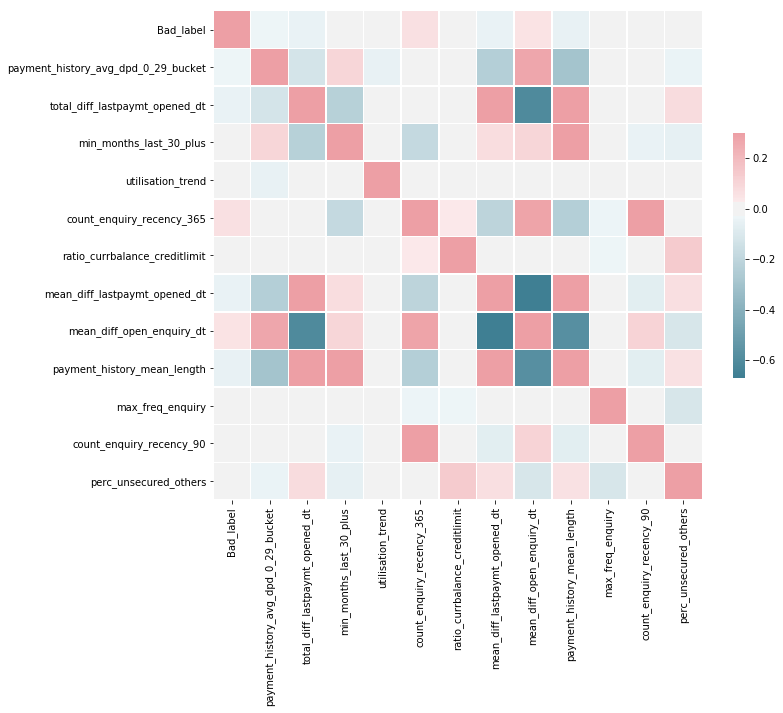

In [117]:
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
df_engineered.columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3096c9b0>,
      dtype=object)

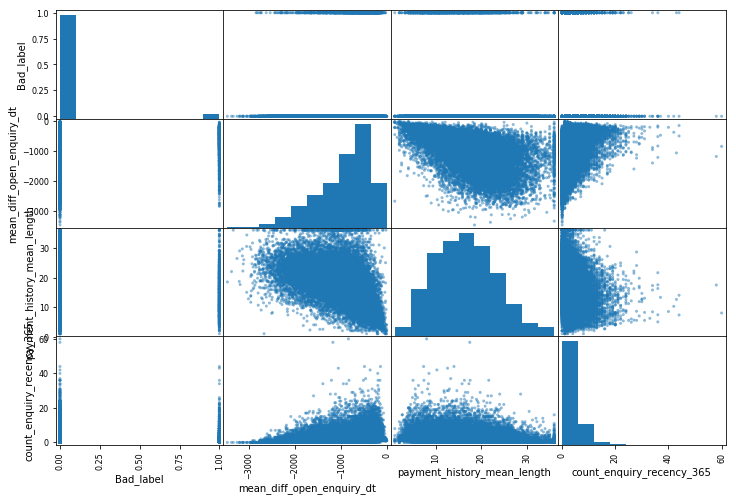

In [263]:
from pandas.plotting import scatter_matrix
attributes = ['Bad_label', 'mean_diff_open_enquiry_dt',
       'payment_history_mean_length', 'count_enquiry_recency_365']
scatter_matrix(df_engineered[attributes], figsize=(12, 8))

**Histogram**

In [237]:
def PlotHistogram(df,norm,variable,target='Bad_label'):
    bins = np.arange(df[variable].min(),df[variable].max())
    plt.figure(figsize=(15,4))
    sns.distplot(df[df[target]==0.0][variable],
                 norm_hist=norm,
                 bins=bins,
                 kde=False,
                 color='b',
                 #hist_kws={'alpha':.5},
                 label='Good')
    sns.distplot(df[df[target]==1.0][variable],
                 norm_hist=norm,
                 bins=bins,
                 kde=False,
                 color='r',
                 label='Bad',
                 #hist_kws={'alpha':.5}
                )
    #plt.xticks(range(0,24))
#    plt.legend()
    plt.show()

(array([2086.,  392.,   54.,    8.,    0.,    0.,    0.,    0.,    0.,
        7658.]), array([  0.99009901,  10.89108911,  20.79207921,  30.69306931,
         40.59405941,  50.4950495 ,  60.3960396 ,  70.2970297 ,
         80.1980198 ,  90.0990099 , 100.        ]), <a list of 10 Patch objects>)

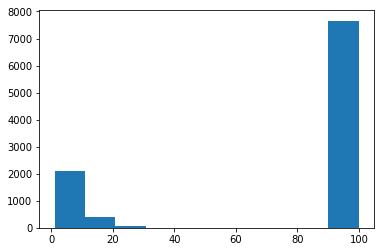

In [254]:
x = df_engineered_test['payment_history_avg_dpd_0_29_bucket']
# plt.hist(np.log(x.as_matrix()+1))
plt.hist(1/(1-x+1e-2))

In [262]:
(df_engineered_test['payment_history_avg_dpd_0_29_bucket']==1).sum()

7658

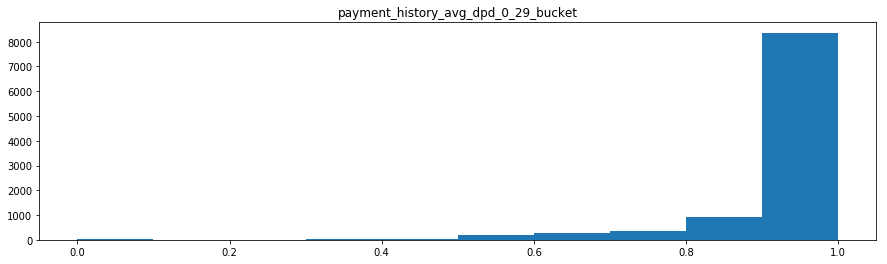

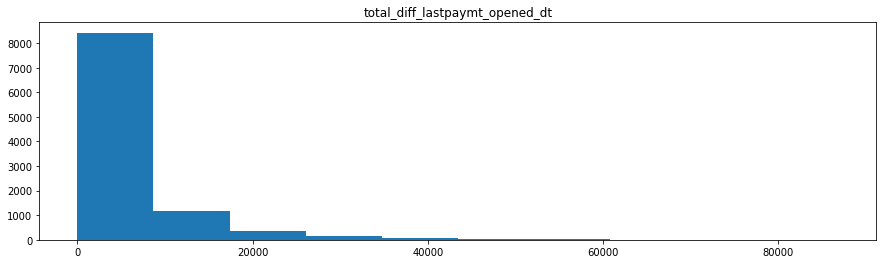

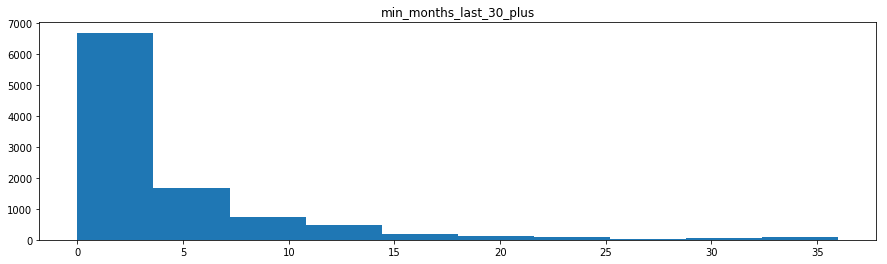

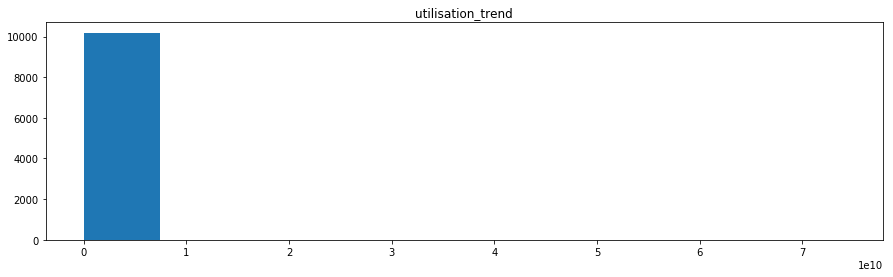

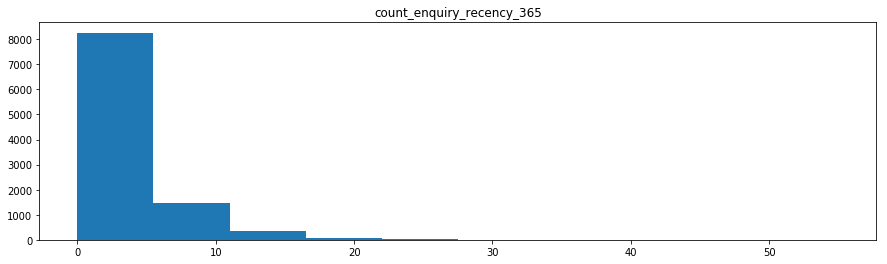

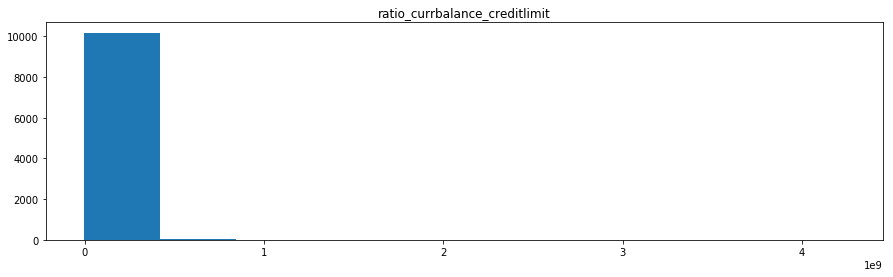

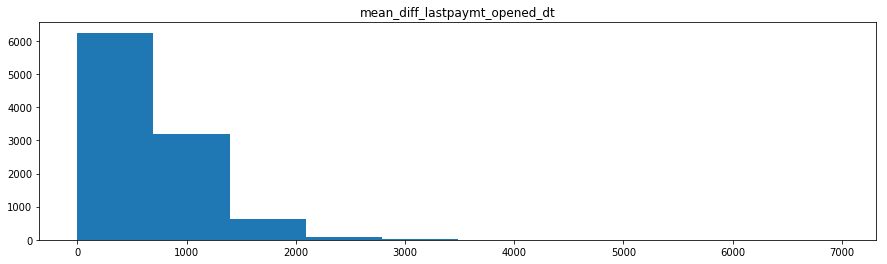

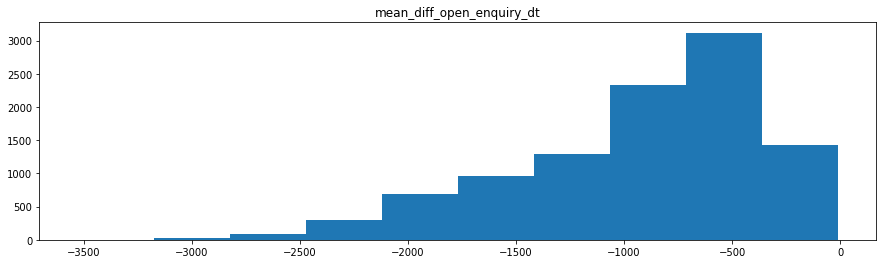

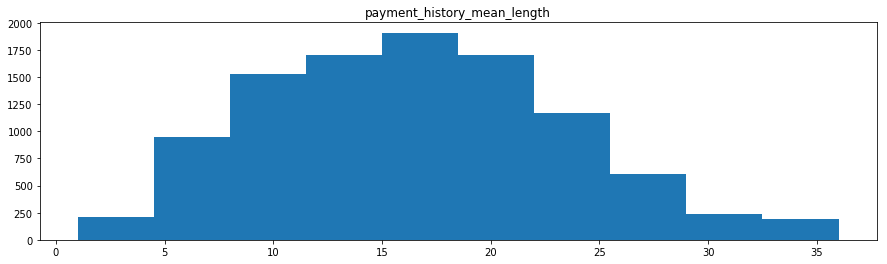

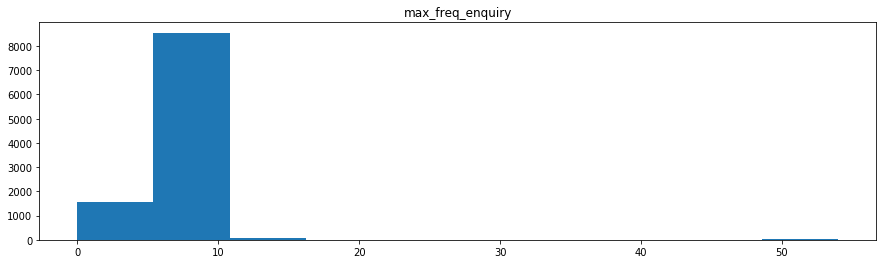

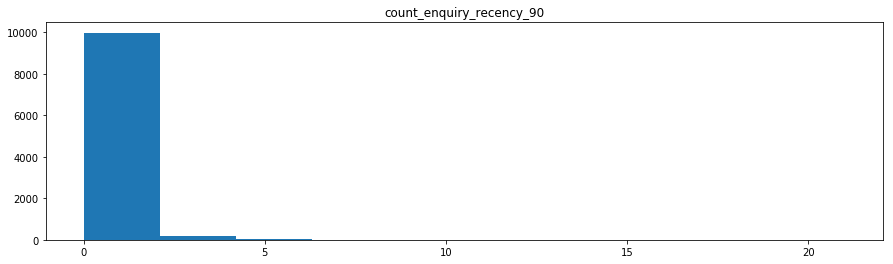

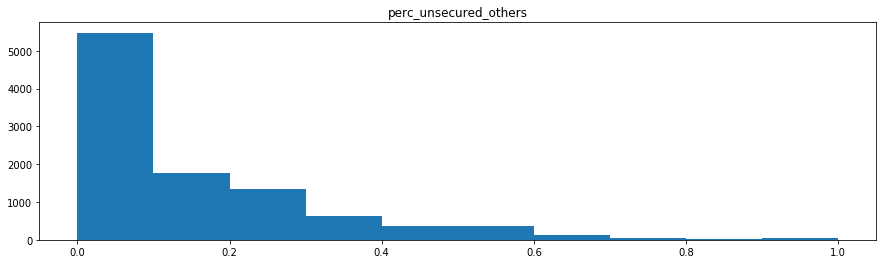

In [259]:
for f in features:
    x = df_engineered_test[f]
    plt.figure(figsize=(15,4))
    plt.hist(x)
    plt.title(f)

Normalized histogram of Good/Bad over hour of the payment_history_avg_dpd_0_29_bucket


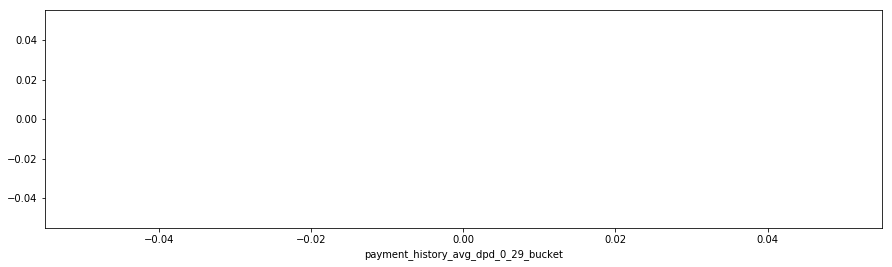

In [239]:
print('Normalized histogram of Good/Bad over hour of the payment_history_avg_dpd_0_29_bucket')
PlotHistogram(df_engineered_test,True,variable='payment_history_avg_dpd_0_29_bucket')

## Feature matrix

#### Information Gain

In [119]:
def entropy(y):
    y = np.array(y)
    if len(y)==0: return 0
    p = y.sum()/len(y)
    if(p>1): raise Exception
    if p==0 or p==1:
        return 0
    else:
        return -np.log2(p)*p-np.log2(1-p)*(1-p)

def condition_entropy(y,x):
    # assume x is continuous
    xy = np.array(sorted(zip(x,y), key=lambda x: x[0]))
    # assume len(x)>100
    min_entr=1
    for i in range(1,100):
        index = round(i/100.*len(x))
        p = index/len(x)
        con_entr = p*entropy(xy[0:index,1])+(1-p)*entropy(xy[index:,1])
        min_entr = min(min_entr, con_entr)
        # print('index={}, entropy={}'.format(index,con_entr))
    return min_entr

def information_gain(y,x):
    return entropy(y)-condition_entropy(y,x)

In [143]:
features = [f for f in df_engineered.columns if f not in ['customer_no','Bad_label']]
for f in features:
    print('information_gain(df_engineered['Bad_label'],df_engineered[f]))

0.0008554874347466157
0.0018207721107092179
0.0001647483462495214
0.0015997252942237805
0.002019120336289426
0.0020850256848824467
0.001964769645244696
0.001877881183726976
0.0019444233940126843
0.0010156240190041244
0.0004344148371119849
0.0006662492858886537


In [264]:
features = [f for f in df_engineered.columns if f not in ['customer_no','Bad_label']]
for f in features:
    print('{}:{}'.format(f,information_gain(df_engineered['Bad_label'],df_engineered[f])))

payment_history_avg_dpd_0_29_bucket:0.0008554874347466157
total_diff_lastpaymt_opened_dt:0.0018207721107092179
min_months_last_30_plus:0.0001647483462495214
utilisation_trend:0.0015997252942237805
count_enquiry_recency_365:0.002019120336289426
ratio_currbalance_creditlimit:0.0020850256848824467
mean_diff_lastpaymt_opened_dt:0.001964769645244696
mean_diff_open_enquiry_dt:0.001877881183726976
payment_history_mean_length:0.0019444233940126843
max_freq_enquiry:0.0010156240190041244
count_enquiry_recency_90:0.0004344148371119849
perc_unsecured_others:0.0006662492858886537


**Mutual Information**

In [122]:
features = [f for f in df_engineered.columns if f not in ['customer_no','Bad_label']]

In [123]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer

X_train = df_engineered[features]
y_train = df_engineered['Bad_label']

# cv = CountVectorizer(max_df=0.95, min_df=2, max_features=10000, stop_words='english')
# X_vec = cv.fit_transform(X_train)

res = dict(zip(X_train.columns,mutual_info_classif(X_train, y_train, discrete_features='auto')))

In [124]:
for v in sorted(res.items(), key=lambda x: x[1],reverse=True):
    print(v)

('max_freq_enquiry', 0.005895632068148915)
('utilisation_trend', 0.0036454733143405083)
('mean_diff_lastpaymt_opened_dt', 0.003369724258835083)
('payment_history_avg_dpd_0_29_bucket', 0.003080038189856138)
('payment_history_mean_length', 0.0021999541017074797)
('mean_diff_open_enquiry_dt', 0.0017922902484768244)
('ratio_currbalance_creditlimit', 0.0013735706528943403)
('perc_unsecured_others', 0.00122307259993093)
('count_enquiry_recency_90', 0.00035285216247360474)
('total_diff_lastpaymt_opened_dt', 0.0)
('min_months_last_30_plus', 0.0)
('count_enquiry_recency_365', 0.0)


## Modeling

In [155]:
from sklearn.metrics import roc_auc_score,accuracy_score, auc,precision_recall_curve,roc_curve
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report,confusion_matrix

In [256]:
features = [f for f in df_engineered.columns if f not in ['customer_no','Bad_label']]
X_train = df_engineered[features]
y_train = df_engineered['Bad_label']
# X_test = df_test[feature_list]

In [153]:
X_test = df_engineered_test[features]
y_test = df_engineered_test['Bad_label']
# X_test = df_test[feature_list]

In [258]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [257]:
X_train.describe()

,payment_history_avg_dpd_0_29_bucket,total_diff_lastpaymt_opened_dt,min_months_last_30_plus,utilisation_trend,count_enquiry_recency_365,ratio_currbalance_creditlimit,mean_diff_lastpaymt_opened_dt,mean_diff_open_enquiry_dt,payment_history_mean_length,max_freq_enquiry,count_enquiry_recency_90,perc_unsecured_others
count,23787.000000,23787.000000,23787.000000,2.378700e+04,23787.000000,2.378700e+04,23787.000000,23787.000000,23787.000000,23787.000000,23787.000000,23787.000000
mean,0.949664,5433.714382,4.239459,3.600964e+07,3.377769,7.369637e+06,686.483447,-927.799857,16.515928,9.173246,0.213604,0.136242
std,0.115987,7313.906925,5.800446,1.375139e+09,3.734174,7.616176e+07,452.811469,571.892118,6.806487,3.405504,0.747025,0.170450
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-1.298679e+08,0.000000,-3466.750000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1269.000000,1.000000,2.029865e+00,1.000000,5.300908e-01,360.535714,-1268.414286,11.333333,10.000000,0.000000,0.000000
50%,1.000000,2946.000000,2.000000,3.422535e+00,2.000000,1.936393e+00,577.142857,-778.166667,16.200000,10.000000,0.000000,0.076923
75%,1.000000,6415.000000,5.000000,5.442866e+00,5.000000,1.006655e+01,896.773810,-487.750000,21.111111,10.000000,0.000000,0.214286
max,1.000000,96440.000000,36.000000,1.394000e+11,60.000000,5.863297e+09,8517.000000,-10.000000,36.000000,54.000000,20.000000,1.000000


Up sampling for imbalanced class

In [166]:
from sklearn.utils import resample

df_minority = df_engineered[y_train==1]
df_majority = df_engineered[y_train==0]
num_class0 = sum(y_train==0)
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=num_class0,    # to match majority class
                                 random_state=23) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['Bad_label'].value_counts()

1    22789
0    22789
Name: Bad_label, dtype: int64

In [168]:
X_train_balanced = df_upsampled[features]
y_train_balanced = df_upsampled['Bad_label']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)
X_test_balanced = scaler.transform(X_test)

**Logistic Regression**

In [172]:
# up sampled
from sklearn.linear_model import LogisticRegression
#for c in [1e-3,1e-2,0.1,1,10,1e2,1e3]:
#for w in [1e-5,1e-3,1e-2,0.1,1,10,1e2,1e3,1e5]:
#for w in [1e-3,1e-2,0.1,1,10,1e2,1e3]:
for w in [1e-3,5e-2,2.5e-2,1e-2,0.5,0.25,0.1]:
    logistic_clf = LogisticRegression(C=10, penalty='l2', class_weight={0:1,1:w})
    # cross_val_score(logistic_clf, X_train, y_train, cv=5, scoring="accuracy")
    cv_pred = cross_val_predict(logistic_clf, X_train_balanced, y_train_balanced, cv=5, method='predict_proba')
    auc = roc_auc_score(y_train_balanced, cv_pred[:,1])
    gini = 2*auc -1
    print('train gini={}'.format(gini))
    logistic_clf.fit(X_train_balanced,y_train_balanced)
    y_pred = logistic_clf.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    gini = 2*auc -1
    print('test gini ={}'.format(gini))
    
    print('---Classification Report---')
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))

train gini=0.26960806360058154
test gini =0.0020033575325708597
---Classification Report---
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      9738
          1       0.06      0.01      0.01       460

avg / total       0.91      0.95      0.93     10198

[[9694   44]
 [ 457    3]]
train gini=0.269144358348107
test gini =0.002106048023431395
---Classification Report---
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      9738
          1       0.07      0.01      0.01       460

avg / total       0.91      0.95      0.93     10198

[[9695   43]
 [ 457    3]]
train gini=0.2694087985820717
test gini =0.002106048023431395
---Classification Report---
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      9738
          1       0.07      0.01      0.01       460

avg / total       0.91      0.95      0.93     10198

[[9695   43]
 [ 457    3]]
tra

In [173]:
from sklearn.linear_model import LogisticRegression
for c in [1e-3,1e-2,0.1,1,10,1e2,1e3]:
    w=20
#for w in [1e-5,1e-3,1e-2,0.1,1,10,1e2,1e3,1e5]:
#for w in [1e-3,1e-2,0.1,1,10,1e2,1e3]:
#for w in [10,15,20,30,40]:
    logistic_clf = LogisticRegression(C=10, penalty='l2', class_weight={0:1,1:w})
    # cross_val_score(logistic_clf, X_train, y_train, cv=5, scoring="accuracy")
    cv_pred = cross_val_predict(logistic_clf, X_train, y_train, cv=5, method='predict_proba')
    auc = roc_auc_score(y_train, cv_pred[:,1])
    gini = 2*auc -1
    print('train gini={}'.format(gini))
    logistic_clf.fit(X_train,y_train)
    y_pred = logistic_clf.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    gini = 2*auc -1
    print('test gini ={}'.format(gini))
    
    print('---Classification Report---')
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))

train gini=0.262728185758502
test gini =0.0022087385142919302
---Classification Report---
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      9738
          1       0.07      0.01      0.01       460

avg / total       0.91      0.95      0.93     10198

[[9696   42]
 [ 457    3]]
train gini=0.262728185758502
test gini =0.0022087385142919302
---Classification Report---
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      9738
          1       0.07      0.01      0.01       460

avg / total       0.91      0.95      0.93     10198

[[9696   42]
 [ 457    3]]
train gini=0.262728185758502
test gini =0.0022087385142919302
---Classification Report---
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      9738
          1       0.07      0.01      0.01       460

avg / total       0.91      0.95      0.93     10198

[[9696   42]
 [ 457    3]]
trai

NameError: name 'X_train_balanced' is not defined

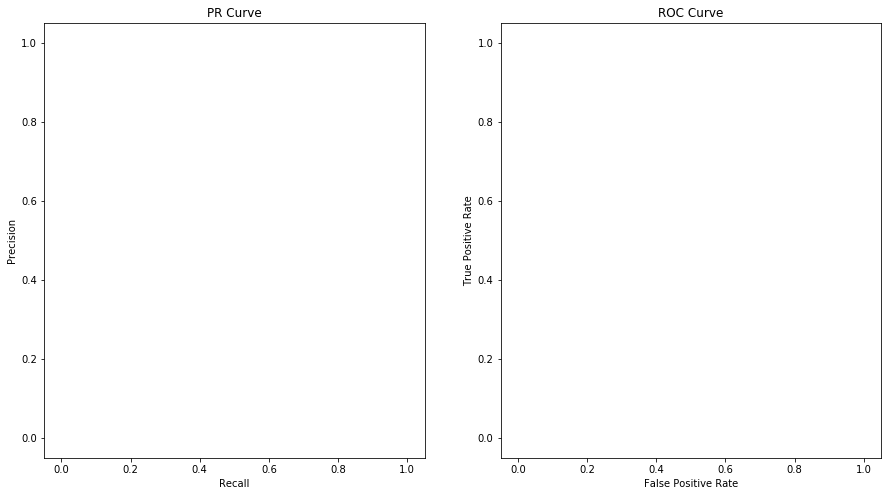

In [164]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for w,k in zip([1,5,10,20,50,100,10000],'bgrcmykw'):
    lr_model = LogisticRegression(class_weight={0:1,1:w})
    lr_model.fit(X_train_balanced,y_train_balanced)
    pred_prob = lr_model.predict_proba(X_train)[:,1]

    p,r,_ = precision_recall_curve(y_train,pred_prob)
    tpr,fpr,_ = roc_curve(y_train,pred_prob)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')

plt.show()

In [ ]:
cv_pred = cross_val_predict(logistic_clf, X_train, y_train, cv=5, method='predict_proba')
cv_pred

In [ ]:
auc = roc_auc_score(y_train, cv_pred[:,1])
gini = 2*auc -1
gini

In [ ]:
logistic_clf.fit(X_train,y_train)
y_pred = logistic_clf.predict(X_train)
print('---Classification Report---')
print(classification_report(y_train,y_pred))
print(confusion_matrix(y_train,y_pred))

**XGBoost**

In [ ]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(n_estimators=5, seed=41,eval_metric='auc')
cross_val_score(xgb_clf, X_train, y_train, cv=5)

In [ ]:
cv_pred = cross_val_predict(xgb_clf, X_train, y_train, cv=5, method='predict_proba')
cv_pred

In [ ]:
auc = roc_auc_score(y_train, cv_pred[:,1])
gini = 2*auc -1
gini

**Random Forest**

In [174]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
cross_val_score(forest_clf, X_train, y_train, cv=5)

array([0.95775536, 0.95754519, 0.95775536, 0.95816691, 0.95794786])

In [210]:
cv_pred=cross_val_predict(forest_clf, X_train, y_train, cv=5,method='predict_proba')
auc = roc_auc_score(y_train, cv_pred[:,1])
gini = 2*auc -1
print(gini)
forest_clf.fit(X_train, y_train)
y_pred = forest_clf.predict(X_train)
print('---Classification Report---')
print(classification_report(y_train,y_pred))
print(confusion_matrix(y_train,y_pred))
y_pred = forest_clf.predict(X_test)
print('---Classification Report---')
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.08078436921233734
---Classification Report---
             precision    recall  f1-score   support

          0       0.99      1.00      0.99     22789
          1       1.00      0.75      0.86       998

avg / total       0.99      0.99      0.99     23787

[[22788     1]
 [  252   746]]
---Classification Report---
             precision    recall  f1-score   support

          0       0.95      1.00      0.98      9738
          1       0.00      0.00      0.00       460

avg / total       0.91      0.95      0.93     10198

[[9738    0]
 [ 460    0]]


/Users/CrazyGear/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fine tune hyper parameter

In [201]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

X=X_train
y=y_train

# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_parameters_`` and
# ``gs.best_index_``
#                  param_grid={'min_samples_split': np.power(2,range(1,18,2))},
gs = GridSearchCV(RandomForestClassifier(random_state=42),
                  param_grid={'min_samples_split': np.ceil(np.power(2,np.linspace(10,11,5))).astype(int)},
                  scoring=scoring, cv=5, refit='AUC',return_train_score=True)
gs.fit(X, y)
results = gs.cv_results_

In [180]:
results

{'mean_fit_time': array([0.42988815, 0.42846956, 0.42664161, 0.41585798, 0.40868883,
        0.3989994 ]),
 'mean_score_time': array([0.02137666, 0.02471285, 0.02354922, 0.02347894, 0.02308459,
        0.02050242]),
 'mean_test_AUC': array([0.54020138, 0.55963052, 0.56079417, 0.57855584, 0.58553275,
        0.58860628]),
 'mean_test_Accuracy': array([0.95783411, 0.95766595, 0.95770799, 0.95800227, 0.95800227,
        0.95804431]),
 'mean_train_AUC': array([0.99981952, 0.99933739, 0.99735994, 0.99101548, 0.97571839,
        0.94923802]),
 'mean_train_Accuracy': array([0.98987895, 0.9817863 , 0.96758734, 0.96034598, 0.95872745,
        0.9583491 ]),
 'param_min_samples_split': masked_array(data=[2, 4, 8, 16, 32, 64],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'min_samples_split': 2},
  {'min_samples_split': 4},
  {'min_samples_split': 8},
  {'min_samples_split': 16},
  {'min_samples_split': 32},
  {'min_

/Users/CrazyGear/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


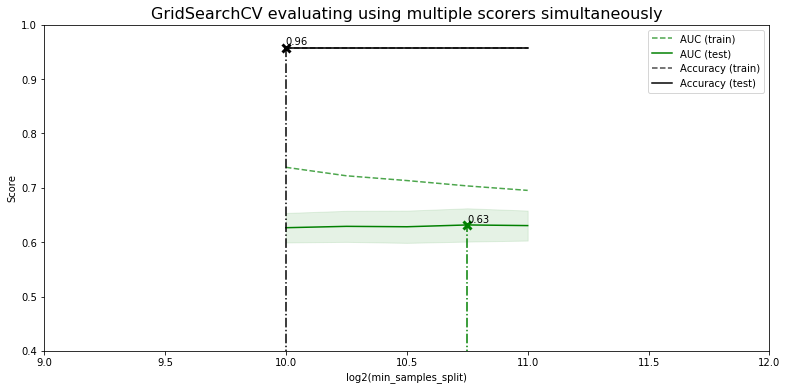

In [205]:
plt.figure(figsize=(13, 6))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("log2(min_samples_split)")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(9, 12)
#ax.set_xlim(0, 20)
ax.set_ylim(0.4, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_min_samples_split'].data, dtype=float)
X_axis = np.log2(X_axis)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))
plt.legend(loc="best")
plt.grid('off')
plt.show()

In [209]:
# for c in np.ceil(np.power(2,np.linspace(4,14,7))).astype(int):
for c in [2,64,256,1024]:
    rdf_clf = RandomForestClassifier(min_samples_split=c)
    rdf_clf.fit(X_train,y_train)
    
    y_pred = rdf_clf.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    gini = 2*auc -1
    
    print('---Classification Report---')
    print('test gini ={}'.format(gini))
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))

test gini =0.024245671372570055
---Classification Report---
             precision    recall  f1-score   support

          0       0.96      0.95      0.95      9738
          1       0.06      0.08      0.07       460

avg / total       0.92      0.91      0.91     10198

[[9212  526]
 [ 424   36]]
test gini =0.0
---Classification Report---
             precision    recall  f1-score   support

          0       0.95      1.00      0.98      9738
          1       0.00      0.00      0.00       460

avg / total       0.91      0.95      0.93     10198

[[9738    0]
 [ 460    0]]


/Users/CrazyGear/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


test gini =0.0
---Classification Report---
             precision    recall  f1-score   support

          0       0.95      1.00      0.98      9738
          1       0.00      0.00      0.00       460

avg / total       0.91      0.95      0.93     10198

[[9738    0]
 [ 460    0]]


/Users/CrazyGear/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


test gini =0.0
---Classification Report---
             precision    recall  f1-score   support

          0       0.95      1.00      0.98      9738
          1       0.00      0.00      0.00       460

avg / total       0.91      0.95      0.93     10198

[[9738    0]
 [ 460    0]]


/Users/CrazyGear/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**SVM**

In [211]:
from sklearn.svm import SVC
for C in [1]:
    svm_clf = SVC(C=C, kernel='rbf',class_weight='balanced',probability=True)
    print('C={}'.format(C))
    print(cross_val_score(svm_clf, X_train, y_train, cv=5))

C=1


KeyboardInterrupt: 

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC(C=1, kernel='rbf',class_weight='balanced')
cv_pred = cross_val_predict(svm_clf, X_train, y_train, cv=5, method='predict_proba')
cv_pred

In [ ]:
auc = roc_auc_score(y_train, cv_pred[:,1])
gini = 2*auc -1
gini

In [217]:
svm_clf = SVC(class_weight='balanced',kernel='rbf')
svm_clf.fit(X_train,y_train)
y_pred = svm_clf.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
gini = 2*auc -1
gini

0.0

In [216]:
y_pred = svm_clf.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
gini = 2*auc -1
gini

0.0

**MLP**

In [218]:
from sklearn.neural_network import MLPClassifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,),activation='tanh')
cv_pred = cross_val_predict(mlp_clf, X_train, y_train, cv=5)
cv_pred

array([0, 0, 0, ..., 0, 0, 0])

In [223]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,))
mlp_clf.fit(X_train_balanced,y_train_balanced)
y_pred = mlp_clf.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
gini = 2*auc -1
gini

-0.08259485475992745

In [228]:
y_pred = mlp_clf.predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred[:,1])
gini = 2*auc -1
gini

-0.10342696027217446